# Download Dataset

In [ ]:
!gdown --id 10fKUF1u3uhIrhEipoklNgysmPyYuYGV9 -O kaggle_m3.zip
!gdown --id 1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ -O data_aug.zip

In [ ]:
! mkdir fakes
! cp data_aug.zip fakes
%cd fakes
! ls

In [ ]:
! unzip data_aug.zip

In [4]:
%cd ..

/content


In [ ]:
!unzip kaggle_m3.zip

# Download Models

In [ ]:
!gdown --id 1lQGkDCBqof5FI36ldZx-q1RGk8P1Q6nu -O brainMRI_Segment.h5
!gdown --id 1zPFJiA6fcCl8y6QkTIXvunqIj_DYR9b0 -O new_cnn_model_full_dataset_color_image.h5
!gdown --id 1-1090IK1tt7irWX-YTV6_L5XbmFh8qO- -O new_vgg_transfer_learning_model_full_dataset_color_image.h5

# Import Data

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
from skimage.color import rgb2gray

import os
import cv2
from PIL import Image
import numpy as np

In [8]:
# Set parameters
file_path='/'
Size = (256, 256)
mask_files = glob(file_path + os.path.join('content','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

# Create Dataframe
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})


df.shape

(5302, 3)

In [9]:
# Collect Data
dataset = [ cv2.imread(path) for path in df["image"]  ]
label = df["label"].values
dataset = np.array(dataset)
label = np.array(df["label"].values).astype(int)
print(dataset.shape)
print(label.shape)

(5302, 256, 256, 3)
(5302,)


# Split Data

In [10]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.1, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4771, 256, 256, 3)
(265, 256, 256, 3)
(266, 256, 256, 3)


In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

# Load models

In [18]:
from keras import backend as K
smooth=1.

def dice_coef(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2.0 * intersection + smooth) / (union + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return dice_coef_loss(y_true, y_pred) + bce(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


model_seg = tf.keras.models.load_model('brainMRI_Segment.h5', custom_objects={'bce_dice_loss': bce_dice_loss, "iou":iou, "dice_coef":dice_coef, "dice_coef_loss":dice_coef_loss})
model_cnn = tf.keras.models.load_model('new_cnn_model_full_dataset_color_image.h5')
model_vgg = tf.keras.models.load_model('new_vgg_transfer_learning_model_full_dataset_color_image.h5')

# Segmentation Classifier

In [19]:
class SegmentationClassifier:
  def __init__(self, model) -> None:
      self.model = model

  def predict(self, images):
      final_pred = []
      y_pred = self.model.predict(images)
      for idx in range(y_pred.shape[0]):
        pred_mask = y_pred[idx]
        result = 1 if np.max(pred_mask.reshape(-1)) > 0.1 else 0
        final_pred.append(result)
      
      return np.array(final_pred)

In [20]:
seg = SegmentationClassifier(model_seg)

In [21]:
seg.predict(X_test)

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0])

# Voting Classifier

In [38]:
from scipy import stats

class VotingClassifier: 
  def __init__(self, models, threshold=0.5) -> None:
      self.models = models
      self.threshold = threshold

  def predict(self, X_test):
      final_pred = []
      for model in self.models:
          y_pred = model.predict(X_test).reshape(-1)
          y_pred = np.where(y_pred >= self.threshold, 1, 0)
          final_pred.append(y_pred)
      final_pred_mode = (stats.mode(final_pred, axis=0)[0]).reshape(-1)
      return final_pred_mode

In [39]:
voting_cls = VotingClassifier([seg, model_cnn, model_vgg])
y_pred = voting_cls.predict(X_test)

In [40]:
y_pred.shape

(265,)

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matraix(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred >= threshold, 1, 0)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, range(2), range(2))
    cm.iloc[0, :] = round(cm.iloc[0, :] / cm.iloc[0, :].sum(), 2)
    cm.iloc[1, :] = round(cm.iloc[1, :] / cm.iloc[1, :].sum(), 2)
    plt.figure(figsize=(10, 10))
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    s = sns.heatmap(cm, annot=True, annot_kws={"size": 32}, fmt="g", cmap="Blues"
)  # font size
    s.set(xlabel="Predicted Label", ylabel="True Label")


### Confusion Matraix for Voting Classifier

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       127
           1       0.98      0.96      0.97       138

    accuracy                           0.97       265
   macro avg       0.97      0.97      0.97       265
weighted avg       0.97      0.97      0.97       265



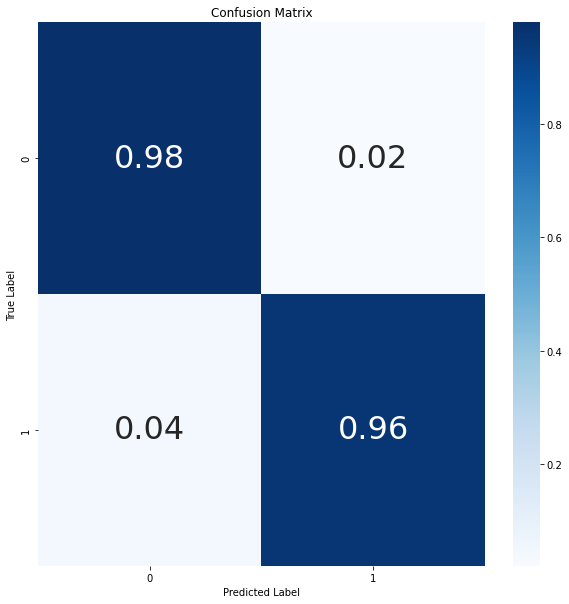

In [57]:
plot_confusion_matraix(voting_cls, X_test, y_test)

### Confusion Matraix for CNN

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       127
           1       0.93      0.93      0.93       138

    accuracy                           0.92       265
   macro avg       0.92      0.92      0.92       265
weighted avg       0.92      0.92      0.92       265



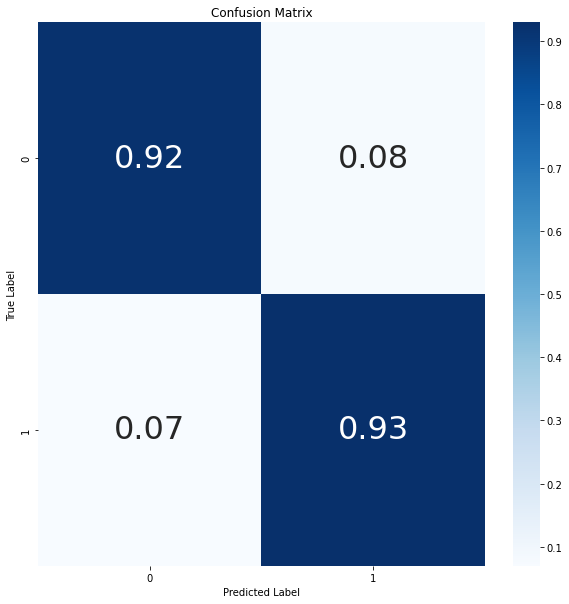

In [58]:
plot_confusion_matraix(model_cnn, X_test, y_test)

### Confusion Matraix for VGG

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       127
           1       0.98      0.93      0.96       138

    accuracy                           0.96       265
   macro avg       0.96      0.96      0.96       265
weighted avg       0.96      0.96      0.96       265



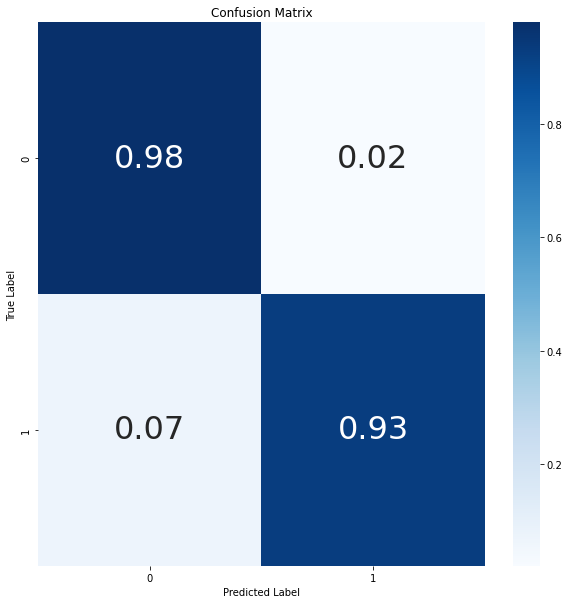

In [59]:
plot_confusion_matraix(model_vgg, X_test, y_test)

### Confusion Matraix for Seg

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       127
           1       0.86      0.96      0.91       138

    accuracy                           0.90       265
   macro avg       0.90      0.90      0.90       265
weighted avg       0.90      0.90      0.90       265



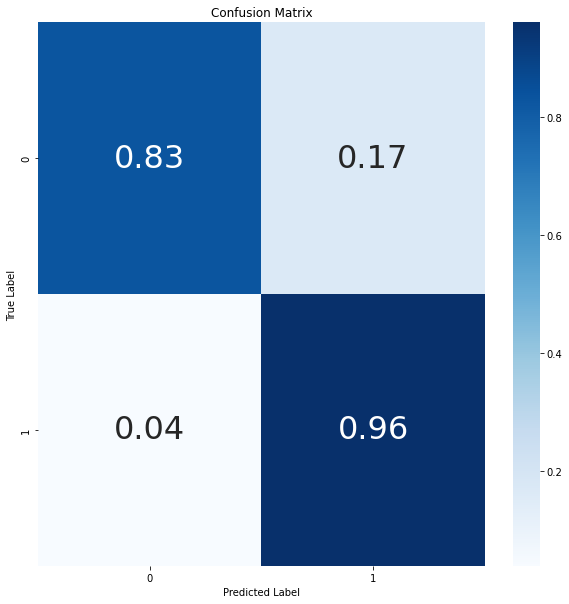

In [60]:
plot_confusion_matraix(seg, X_test, y_test)